In [239]:
# Load datasets and store in dictionaries
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR, SVC
from abess import LinearRegression
from abess.decomposition import SparsePCA
from kennard_stone import train_test_split as ks_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [56]:
def get_y_value(path):
    Y_value = pd.read_csv(path, index_col=0)
    Y_value.reset_index(inplace=True, drop=True)
    return Y_value

def get_x_value(path):
    X = pd.read_csv(path, sep='\t', index_col=0, low_memory=False)
    X.reset_index(inplace=True, drop=True)
    X.drop('NAME', axis=1, inplace=True)
    return X

In [57]:
y_values = dict()
for item in os.listdir('.'):
    if '.csv' in item:
        y_values[item[:-4]] = get_y_value(item)

In [58]:
x_values = dict()
for item in os.listdir('.'):
    if '.txt' in item:
        x_values[item[5:-4]] = get_x_value(item)

In [62]:
y_values['HadarDataSet'].head(10)

,SMILES,Electrolyte,Semiconductor,Solar simulator,Article DOI,Molecule keywords,Molecule spectrum absorption maxima,Molecule spectrum emission maxima,VOC,JSC,FF,PCE
0,N#C/C(=C\c1ccc(cc1)N(c1ccccc1)CCCCCCN1c2ccccc2...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.011,phenothiazine,439.0,576.0,687.0,10.79,0.70,5.19
1,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,"coumarin, triphenylamine",465.0,640.0,678.0,13.20,0.67,6.00
2,N#C/C(=C\c1ccc(s1)c1ccc(cc1)N(c1ccc(cc1)/C=C/c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,"coumarin, triphenylamine",460.0,590.0,695.0,12.20,0.74,6.20
3,CCN(c1ccc2c(c1)oc(=O)c(c2)/C=C/c1ccc(cc1)N(c1c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,"coumarin, triphenylamine",454.0,525.0,800.0,9.00,0.76,5.50
4,CCN([C@@H]1C=Cc2c(C1)oc(=O)c(c2)c1ccc(cc1)c1cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,465.0,490.0,560.0,3.41,0.73,1.39
5,CCN(c1ccc2c(c1)oc(=O)c(c2)c1ccc(cc1)c1ccc(s1)C...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,438.0,500.0,660.0,7.72,0.71,3.62
6,CCN(c1ccc2c(c1)oc(=O)c(c2)c1ccc(cc1)c1ccc(cc1)...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,425.0,487.0,600.0,4.03,0.73,1.77
7,CCN(c1ccc2c(c1)oc(=O)c(c2)c1ccc(cc1)c1ccc(cc1)...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,413.0,490.0,690.0,5.79,0.70,2.80
8,CCN(c1ccc2c(c1)oc(=O)c(c2)c1ccc(cc1)/C=C(\[C@H...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,449.0,494.0,580.0,3.33,0.73,1.41
9,CCN(c1ccc2c(c1)oc(=O)c(c2)c1ccc(cc1)/C=C(\C(=O...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.orgel.2017.06.013,coumarin,420.0,510.0,709.0,6.79,0.70,3.10


In [63]:
def add_family_to_x(y_dict, x_dict):
    x_dict_plus_fam = dict()
    for dataset in y_dict:
        dataset_plus_fam = pd.concat([x_dict[dataset], y_dict[dataset]['Molecule keywords']], axis=1)
        x_dict_plus_fam[dataset] = dataset_plus_fam
    return x_dict_plus_fam
        

In [211]:
X = add_family_to_x(y_values, x_values)

In [87]:
def top_families(n_families, y_dict):
    top_families = dict()
    for dataset in y_dict:
        family_list = list(y_dict[dataset].groupby(['Molecule keywords']).count().sort_values('PCE', ascending=False).head(n_families).index)
        top_families[dataset] = family_list
    return top_families

In [212]:
top_compound_families = top_families(7, y_values)

In [213]:
def rename_uncommon_families(top_families, x_dict):
    for dataset in x_dict:
        x_dict[dataset].loc[(~x_dict[dataset]['Molecule keywords'].isin(top_families[dataset])), 'Molecule keywords'] = 'other'
#         for family in top_families[dataset]:
#             df_x = x_dict[dataset].loc[x_dict[dataset]['Molecule keywords'].isin(top_families[dataset])]
#             trimmed_x[dataset] = df_x   
    return x_dict

In [214]:
X_dict = rename_uncommon_families(top_compound_families, X)

In [215]:
X_dict['HadarDataSet'].groupby(['Molecule keywords']).count().sort_values('MW', ascending=False)

,MW,AMW,Mp,Mi,GD,nAA,nTA,RBN,RBF,nDB,...,F10[O-F],F10[O-B],F10[S-S],Ui,Hy,TPSA(NO),TPSA(Tot),LOGP99,SAdon,SAscore
Molecule keywords,,,,,,,,,,,,,,,,,,,,,
triphenylamine,564,564,564,564,564,564,564,564,564,564,...,564,564,564,564,564,564,564,564,564,564
other,328,328,328,328,328,328,328,328,328,328,...,328,328,328,328,328,328,328,328,328,328
phenothiazine,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
carbazole,135,135,135,135,135,135,135,135,135,135,...,135,135,135,135,135,135,135,135,135,135
indoline,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
coumarin,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
diphenylamine,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
imidazole,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [219]:
def ordinalEncode_compound_family(X):
    X_encoded = dict()
    for dataset in X:
        encoder = OrdinalEncoder()
        X[dataset][['Molecule keywords']] = encoder.fit_transform(X[dataset][['Molecule keywords']])
        X[dataset]['Molecule keywords'] = X[dataset]['Molecule keywords'].astype(int)
        X_encoded[dataset] = X[dataset]
    
    return X_encoded

In [220]:
X_raw = ordinalEncode_compound_family(X_dict)

In [221]:
X_raw['HadarDataSet'].groupby(['Molecule keywords']).count().sort_values('MW', ascending=False)

,MW,AMW,Mp,Mi,GD,nAA,nTA,RBN,RBF,nDB,...,F10[O-F],F10[O-B],F10[S-S],Ui,Hy,TPSA(NO),TPSA(Tot),LOGP99,SAdon,SAscore
Molecule keywords,,,,,,,,,,,,,,,,,,,,,
7,564,564,564,564,564,564,564,564,564,564,...,564,564,564,564,564,564,564,564,564,564
5,328,328,328,328,328,328,328,328,328,328,...,328,328,328,328,328,328,328,328,328,328
6,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
0,135,135,135,135,135,135,135,135,135,135,...,135,135,135,135,135,135,135,135,135,135
4,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
1,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
2,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
3,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [222]:
def multi_train_test_split(x_dict, y_dict):
    all_cases = dict()
    for dataset in y_dict:
        train_test_dict = dict()
        X_train, X_test, Y_train, Y_test = train_test_split(x_dict[dataset], y_dict[dataset]['PCE'], test_size=0.3)
        train_test_dict['X_train'] = X_train
        train_test_dict['X_test'] = X_test
        train_test_dict['Y_train'] = Y_train
        train_test_dict['Y_test'] = Y_test
        all_cases[dataset] = train_test_dict
    return all_cases

In [223]:
train_test_sets = multi_train_test_split(X_raw, y_values)

In [224]:
train_test_sets['HadarDataSet']['X_test'].shape

(439, 548)

<h2>Global Model Without RFE or Model Optimisation</h2>

In [247]:
def blunt_model(input_train_test_sets):
    for dataset in input_train_test_sets:
        X_train = input_train_test_sets[dataset]['X_train']
        Y_train = input_train_test_sets[dataset]['Y_train']
        X_test = input_train_test_sets[dataset]['X_test']
        Y_test = input_train_test_sets[dataset]['Y_test']
        
        model = RandomForestRegressor(n_estimators = 1000)
        model.fit(X_train, Y_train)
        
        predict_test = model.predict(X_test)
        r2_test = r2_score(Y_test, predict_test)
        
        results = results_df(Y_test, predict_test, X_test)
        
        plt.figure(figsize=(9,9))
        sns.scatterplot(data=results, x='True', y='Predicted', hue = 'Compound Family')
#         
#         plt.scatter(Y_test, predict_test, c='crimson')
        
#         p1 = max(max(predict_test), max(Y_test))
#         p2 = min(min(predict_test), min(Y_test))
#         plt.plot([p1, p2], [p1, p2], 'b-')
#         plt.xlabel('True Values', fontsize=15)
#         plt.ylabel('Predictions', fontsize=15)
#         plt.axis('equal')
        plt.title(f"Dataset: {dataset} Correlation: {round(r2_test, 2)}")
        plt.show()
        

In [249]:
def results_df(Y_test, predict_test, X_test):
    data = dict()
    data['True'] = Y_test
    data['Predicted'] = predict_test
    data['Compound Family'] = X_test['Molecule keywords'].astype(str)
    df = pd.DataFrame(data)
    return df
    

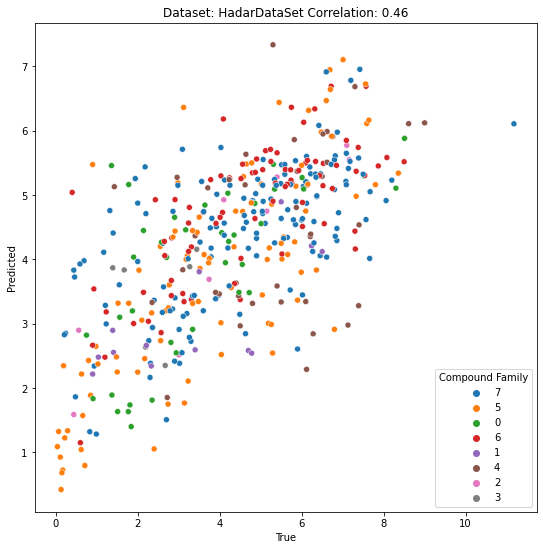

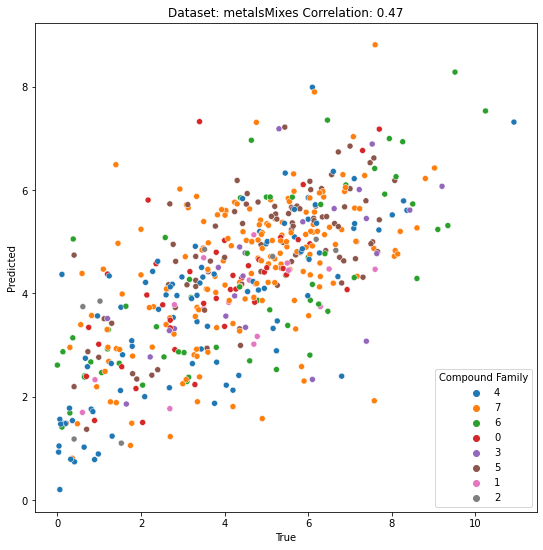

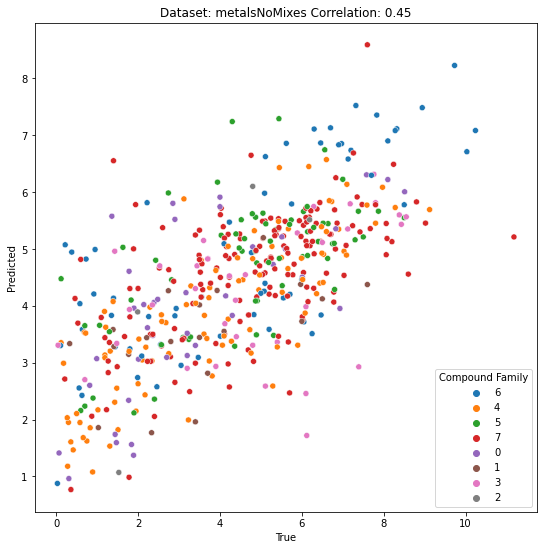

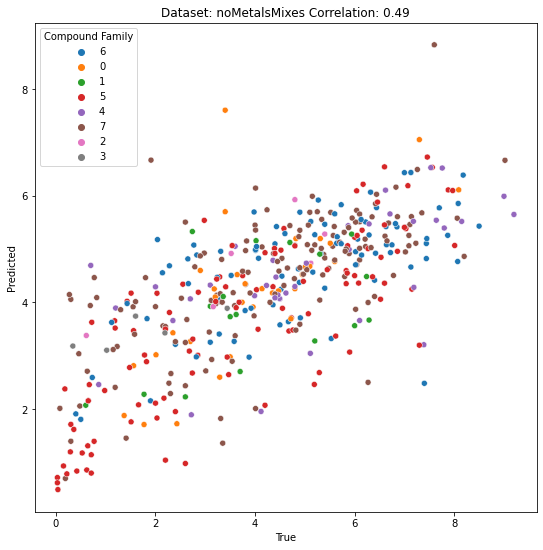

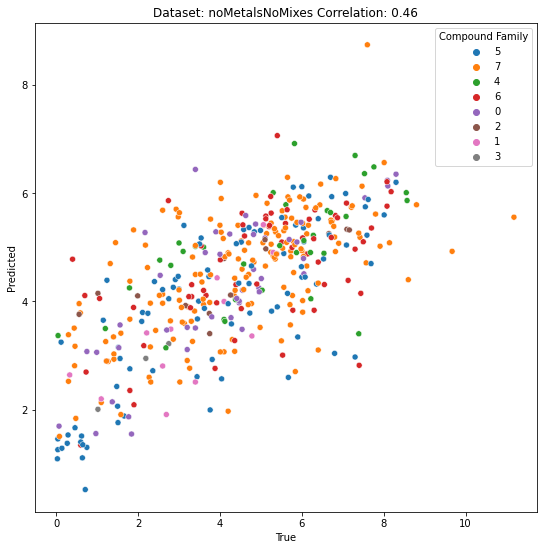

In [250]:
blunt_model(train_test_sets)

<h2>RFE</h2>

In [251]:
def multi_rfeCV(input_train_test_sets):
    for dataset in input_train_test_sets:
        X_train = input_train_test_sets[dataset]['X_train']
        Y_train = input_train_test_sets[dataset]['Y_train']
        
        model = RandomForestRegressor()
        
        rfeCV = RFECV(
            estimator=model,
            step=100,
            cv=10,
            scoring='r2',
            min_features_to_select=1
        )
        
        rfeCV.fit(X_train, Y_train)
        
        plt.figure()
        plt.plot(range(min_features_to_select, len(X_train.columns)),
                 rfeCV.grid_scores_
                )
        plt.xlabel("Number of Features")
        plt.ylabel("Cross validation score (r2)")
        plt.title(f"Datase: {dataset}, Best n_features: {rfeCV.n_features_}")
        plt.show()

In [ ]:
multi_rfeCV(train_test_sets)